IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import torch
import string
import torchtext
from torchtext.datasets import IMDB
from torchtext.data.functional import to_map_style_dataset, sentencepiece_tokenizer
from torch.utils.data import DataLoader, TensorDataset
import nltk
from nltk.corpus import wordnet, stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re
from gensim.models import Word2Vec
from nltk.corpus import sentiwordnet as swn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('sentiwordnet')

[nltk_data] Downloading package wordnet to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

LOADING DATASET

<Axes: xlabel='Sentiment_Labels'>

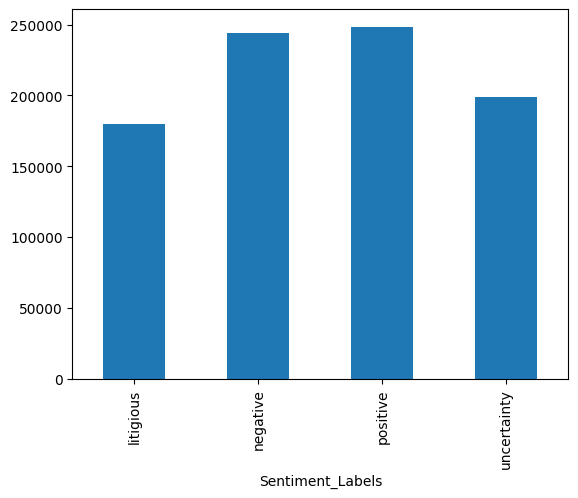

In [3]:
# Filter only English tweets
# Convert all columns to string type
# Drop all rows with any NaN and NaT values
UnC_Data = pd.read_csv('./Dataset/Text/4/dataset.csv', low_memory=False).query('Language == "en"').astype(str).dropna()

# Only keep the text and label columns
UnC_Data = UnC_Data[['Text', 'Label']]

# Rename the "Label" column as "sentiment labels"
UnC_Data = UnC_Data.rename(columns={'Label': 'Sentiment_Labels'})

# Visualize the distribution of the labels
UnC_Data.groupby(['Sentiment_Labels']).size().plot.bar()

DATA PREPROCESSING

In [4]:
# Cleaning the dataset of unwanted characters and symbols and preprocessing the text

# Pre-compiling regular expressions
emoji_pattern = re.compile("["                    
u"\U0001F600-\U0001F64F"                      
u"\U0001F300-\U0001F5FF"
u"\U0001F680-\U0001F6FF"
u"\U0001F1E0-\U0001F1FF"
u"\U00002702-\U000027B0"
u"\U000024C2-\U0001F251"
"]+", flags=re.UNICODE)

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

#Function to clean and preprocess the text (Removing emojis, unwanted characters, tokenizing, lemmatizing, and removing stop words.)
def clean_and_preprocess(tweet):
    if isinstance(tweet, float):
        return ""

    # Remove emojis and unwanted characters efficiently
    temp = tweet.lower()
    temp = emoji_pattern.sub(r'', temp)  # Remove emojis
    temp = temp.translate(str.maketrans('', '', string.punctuation))  # Punctuation removal
    temp = re.sub(r'http\S+', '', temp)  # Remove URLs
    temp = re.sub(r'\s+', ' ', temp).strip()  # Remove extra spaces
    temp = re.sub("'", "", temp)
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#","", temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)

    # Tokenization and Lemmatization (NLTK library)
    words = nltk.word_tokenize(temp)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return lemmatized_words

# Rename the dataframe to C_Data (Clean Data) and apply the clean_and_preprocess function to the "Text" column)
C_Data = UnC_Data.copy()
C_Data['Text'] = C_Data['Text'].apply(clean_and_preprocess)

In [9]:
# Assuming your labels are in a column called 'Sentiment_Labels'
label_mapping = {'positive': 0, 'negative': 1, 'uncertainty': 2, 'litigious': 3}  # Adjust for your labels

# Convert all labels to numerical values
C_Data['Numerical_Labels'] = C_Data['Sentiment_Labels'].map(label_mapping)

# Only keep the text and label columns
C_Data = C_Data[['Text', 'Numerical_Labels']]


In [10]:
C_Data.head()

,Text,Numerical_Labels
0,"[charliecorley, kristine1g, amyklobuchar, styl...",3
2,"[flagstar, bank, discloses, data, breach, impa...",3
3,"[rwanda, set, host, headquarters, united, nati...",0
4,"[oops, typed, name, incorrectly, today, brave,...",3
5,"[suck, since, im, focused, nature, aspect, thi...",1


In [11]:
# Save the preprocessed dataset to a CSV file for easier access
C_Data.to_csv('./Dataset/Text/4/C_Data.csv', index=False)

In [12]:
# Flatten the list of lists into a single list
all_words = [word for words in C_Data['Text'] for word in words]

# Create Word2Vec model
word2vec_model = Word2Vec(sentences=[all_words], vector_size=100, window=5, min_count=1, workers=4)

# Save the Word2Vec model to a file
word2vec_model.save("word2vec_model.model")

# Function to get sentiment score for a word from SentiWordNet
def get_sentiment_score(word):
    synsets = list(swn.senti_synsets(word))
    if not synsets:
        return 0.0
    # Use the average of all found synsets
    score = np.mean([synset.pos_score() - synset.neg_score() for synset in synsets])
    return score

# Combine Word2Vec embeddings with sentiment scores from SentiWordNet
def get_word_embedding(word):
    if word in word2vec_model.wv:
        word_embedding = word2vec_model.wv[word]
    else:
        word_embedding = np.zeros(word2vec_model.vector_size)  # Use zero vector for out-of-vocabulary words
    
    sentiment_score = get_sentiment_score(word)
    return np.concatenate([word_embedding, [sentiment_score]])

# Create a dictionary of word embeddings
word_embeddings = {word: get_word_embedding(word) for word in word2vec_model.wv.index_to_key}

# Save the combined word embeddings to a file
np.save("word_embeddings.npy", word_embeddings)


In [14]:
# Assume you have a column 'Sentiment_Labels' in C_Data that contains sentiment labels (positive/negative/neutral)
labels = C_Data['Numerical_Labels']

# Split the dataset into train, test, and validation sets
train_data, test_data = train_test_split(C_Data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Save the train, test, and validation datasets to CSV files
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)


In [15]:
# Check the count of each dataset
print("Train data count:", train_data.shape[0])
print("Test data count:", test_data.shape[0])
print("Validation data count:", val_data.shape[0])

Train data count: 697048
Test data count: 87131
Validation data count: 87131


In [18]:
print(train_data['Text'])

927821    [inbox, lt100, get, easier, deeper, archaeolog...
267208    [thanx4liquidity, course, would, miss, pattern...
16544     [college, ready, launched, training, school, l...
886932    [crediblecustos, lt, around, corner, next, par...
72339     [deny, best, policy, organisation, policy, imp...
                                ...                        
278805    [legal, aid, rule, set, limit, fee, mean, soli...
393726    [kamikazeth, tszzl, country, born, america, to...
141951    [cherrypoolbitch, see, kinda, money, come, tim...
722400    [good, question, autism, absorbed, gender, pol...
131215    [survivorjon, nod, he, got, high, upside, remi...
Name: Text, Length: 697048, dtype: object


In [17]:

if len(train_data) > 0:
    tokenizer = get_tokenizer('spacy')

    def yield_tokens(data_iter):
        for text_list in data_iter:
            if isinstance(text_list, list):
                # If 'Text' is a list of tokens, join them into a string
                text = ' '.join(text_list)
            else:
                # If 'Text' is already a string, use it as is
                text = text_list

            yield tokenizer(text)

    # Tokenize each text instance in the training dataset
    tokens = yield_tokens(train_data['Text'])

    # Build vocabulary from the tokenized text
    vocab = build_vocab_from_iterator(tokens, specials=['<unk>'])

    # # Assuming your labels are in a column called 'Sentiment_Labels'
    # label_mapping = {'positive': 0, 'negative': 1, 'uncertainty': 2, 'litigious': 3}  # Adjust for your labels

    # # Convert all labels to numerical values
    # train_data['Numerical_Labels'] = train_data['Sentiment_Labels'].map(label_mapping)

    # Create tensors for text and labels
    text_field = torch.tensor(
        [list(map(vocab.get_stoi, tokenizer(text))) for text in train_data['Text']],
        dtype=torch.long
    )
    label_field = torch.tensor(train_data['Numerical_Labels'].tolist(), dtype=torch.long)
else:
    print("Empty train_data DataFrame.")





TypeError: Argument 'string' has incorrect type (expected str, got list)